## Fine-grained hate speech detection - Multilabel classification

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/HOMO-MEX/task_2')

In [3]:
from config import config

In [4]:
%%capture
#! pip install --quiet "torchvision" "torch>==1.10" "pytorch-lightning>=1.3" "torchmetrics>=0.3" "typing-extensions<4,>=3.7.4.3" "tf-estimator-nightly==2.8.0.dev2021122109" "folium==0.2.1"
! pip install torchmetrics

In [5]:
%%capture
!pip install transformers # pre-trained models from https://huggingface.co/

### Import all the libraries and functions we will use

In [6]:
import re
import os
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import BertModel

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler

from torchmetrics.classification import MultilabelF1Score

pd.set_option('display.max_colwidth',None)

### Environment set up


Select the device where the model is to be trained.

In [7]:
run_on = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(run_on)
DEVICE

device(type='cuda')

Set a random seed to ensure that the results are reproducible when attempting to run this *notebook* again.

In [8]:
# set random seed
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed_all(value)

set_seed(config.RANDOM_STATE)

### Dataset

In [9]:
class CustomDataset:
  def __init__(self, datapath, version, batch_size, modelname, test_size=0.2):
    self.datapath = datapath
    self.batch_size = batch_size
    self.dataloaders = {}
    self.dfs = {}
    self.tokenizer = BertTokenizerFast.from_pretrained(modelname
                                          ,do_lower_case=(True if 'uncased' in modelname else False))
    self.prepareData(version)

  def prepareData_kfold(self):
    df = pd.read_csv(self.datapath, converters={config.TEXT:str})
    df.drop(columns=["Unnamed: 0"], inplace=True)
    df["labels"] = df["L"].map(str) + df["G"].map(str) + df["B"].map(str) + df["T"].map(str) + df["O"].map(str) + df["NR"].map(str)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.RANDOM_STATE)
    kfolds = skf.split(df[config.TEXT], df["labels"])

    for i, (train_index, test_index) in enumerate(kfolds):
      train = df.iloc[list(train_index)]
      test = df.iloc[list(test_index)]

      train = train.sample( len(train), random_state=config.RANDOM_STATE )
      test = test.sample( len(test), random_state=config.RANDOM_STATE )

      self.dfs[i] = { "train": train, "val": test }
      self.dataloaders[i] = { "train": self.getTensorDataset(train), "val": self.getTensorDataset(test) }

    return self.dataloaders

  def prepareData(self, version):
    dataset_names = [ "train", "dev", "test" ]
    for key in dataset_names:
      df = pd.read_csv(f"{self.datapath}{key}_{version}.csv", converters={ config.TEXT:str })
      if key == "train":
        df = df.sample( len(df), random_state=config.RANDOM_STATE )

      inputs, masks = self.tokenize(df["text"])

      if config.TARGETS[0] in list(df.columns):
        labels = torch.tensor(df[config.TARGETS].values, dtype=torch.float32)
        data = TensorDataset(inputs, masks, labels)
      else:
        df[config.ID] = df[config.ID].apply(lambda x: int(x.replace("_Track2", "")))
        ids = torch.tensor(df[config.ID].to_numpy(), dtype=torch.float32)
        data = TensorDataset(inputs, masks, ids)

      sampler = SequentialSampler(data)
      self.dfs[key] = df
      self.dataloaders[key] = DataLoader(data,
                                         sampler=sampler,
                                         batch_size=self.batch_size,
                                         num_workers=0)
      print("...dataloader for", key, "completed")
    return self.dataloaders

  def getTensorDataset(self, dataset):
    inputs, masks = self.tokenize(dataset[config.TEXT])
    #labels = torch.tensor(dataset[config.TARGET].to_numpy(), dtype=torch.long)
    labels = torch.tensor(dataset[config.TARGETS].values, dtype=torch.float32)
    data = TensorDataset(inputs, masks, labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=self.batch_size, num_workers=0)
    return dataloader

  def tokenize(self, dataset):
    input_ids = []
    attention_mask = []

    for doc in dataset:
      encoded_doc = self.tokenizer.encode_plus(doc,
                                          add_special_tokens=True,
                                          max_length=config.TASK2_MAXLEN,
                                          truncation=True,
                                          padding="max_length",
                                          return_token_type_ids=False
                                          )

      input_ids.append(encoded_doc['input_ids'])
      attention_mask.append(encoded_doc['attention_mask'])

    return (torch.tensor(input_ids), torch.tensor(attention_mask))

### Training

This process consists of transforming the words of the messages into features expected by BETO.


In [10]:
# PARAMETERS

# Model
NUM_LABELS = 6

# Training
BATCH_SIZE = 8
GRADIENT_ACCUMULATOR_SIZE = 1
NUM_EPOCHS = 25

GET_ATTENTIONS = False
GET_HIDDEN_STATES = False
DROPOUT = 0.07

# Optimizer
LR = 4e-5
EPS = 1e-10
WEIGHT_DECAY = 0
BETAS = (0.9, 0.999)
AMSGRAD = False

# Loss
REDUCTION = "sum"
LABEL_SMOOTHING = 0

# Scheduler
POWER = 1.0

In [11]:
#fuction to format time
def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_rounded))

#function to clean cuda memory
def clean_cuda_memory(iterable_var):
  for elem in iterable_var:
    elem.to('cpu')
    del elem
  torch.cuda.empty_cache()
  gc.collect()

def get_class_weights(classes_list, labels):
  return compute_class_weight('balanced', classes=classes_list, y=labels)

#variable to plot the confusion matrix
conf = []

In [12]:
class TextClassifier(nn.Module):
  def __init__(self, modelpath, freeze_model=False, num_labels=2, get_att=False, get_hs=False, dropout=0.05):
    super(TextClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(modelpath
                                          ,num_labels=num_labels
                                          ,output_attentions=get_att
                                          ,output_hidden_states=get_hs)

    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)
    self.freeze_model = freeze_model

    if self.freeze_model:
        for param in self.bert.parameters():
            param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids
                        ,token_type_ids=None
                        ,attention_mask=attention_mask)

    pooled_output = outputs.pooler_output
    pooled_output = self.dropout(pooled_output)
    logits = self.fc(pooled_output)
    return logits

In [13]:
class CustomModel:
  def __init__(self, modelpath, class_weights):
    self.model = TextClassifier(modelpath, num_labels=NUM_LABELS, get_att=GET_ATTENTIONS, get_hs=GET_HIDDEN_STATES, dropout=DROPOUT)

    self.optimizer = torch.optim.Adam(self.model.parameters()
                                      ,lr = LR
                                      ,eps = EPS
                                      ,weight_decay = WEIGHT_DECAY
                                      ,betas = BETAS # 0.9, 0.999
                                      ,amsgrad = AMSGRAD)

    self.criterion = nn.CrossEntropyLoss(weight=class_weights # torch.tensor([5.8, 0.43, 2]).to(device)
                                         ,reduction = REDUCTION #sum
                                         ,label_smoothing = LABEL_SMOOTHING)

  def freeze_all(self):
    #Freeze all layers except classifier
    for name, param in self.model.named_parameters():
      if "encoder.layer" in name:
        param.requires_grad = False

  def unfreeze(self, layers=np.arange(0,12,1)):
    self.freeze_all()
    #Unfreeze specified layers
    for layer_no in layers:
      for name, param in self.model.named_parameters():
        if "encoder.layer" in name and str(layer_no) in name:
          param.requires_grad = True

  def freeze_embs(self):
    for name, param in self.model.named_parameters():
      if "embeddings" in name:
        param.requires_grad = False

  def validation(self, val_dataloader):
    t0 = time.time()

    # We put the model in validation mode
    self.model.eval()

    # We declare variables
    eval_loss = 0
    eval_metric = 0
    all_logits = []
    all_labels = []

    # By minibatches
    for step, batch in enumerate(val_dataloader):
      b_input_ids, b_input_mask, b_labels = tuple(t.to(DEVICE) for t in batch)

      with torch.no_grad():
        # We generate the predictions of the model
        outputs = self.model(b_input_ids,
                            attention_mask=b_input_mask)

        loss = self.criterion(outputs, b_labels)

        # ...we extract them
        logits = torch.round(torch.sigmoid(outputs)).detach().cpu()
        b_labels = b_labels.to('cpu')

        # Saving logits and labels. They will be useful for the confusion matrix.
        #predict_labels = np.argmax(logits, axis=1).flatten()
        all_logits.extend(logits.tolist())
        all_labels.extend(b_labels.tolist())

        eval_loss += loss

    # We calculate the F1 score of this batch
    scores = MultilabelF1Score(num_labels=NUM_LABELS, average=None)(torch.tensor(all_logits), torch.tensor(all_labels))

    # We show the final accuracy for this epoch
    print(f"\n\tF1Scores: {scores.tolist()}")
    print(f"\n\tEvalLoss: {eval_loss}")
    print(f"\tValidation took: {format_time(time.time() - t0)}")
    return scores, eval_loss


  def training(self, n_epochs, train_dataloader, val_dataloader, gradient_accumulator_size=2):
    max_step_t = len(train_dataloader)
    max_step_v = len(val_dataloader)

    scheduler = torch.optim.lr_scheduler.PolynomialLR(self.optimizer
                                                      ,total_iters=n_epochs
                                                      ,power=POWER)

    total_loss = []
    total_lr = []

    for epoch in range(n_epochs):
      # for each epoch...
      print(f"\nEpoch {epoch + 1} / {n_epochs} :")
      # We save the start time to see how long it takes.
      t0 = time.time()
      # We reset the loss value for each epoch.
      epoch_loss = []

      # Training mode.
      self.model.train()
      self.model.zero_grad()

      for step, batch in enumerate(train_dataloader):
        batch_loss = 0
        b_input_ids, b_input_mask, b_labels = tuple(t.to(DEVICE) for t in batch)

        # Propagation forward in the layers
        outputs = self.model(b_input_ids,
                        attention_mask=b_input_mask)

        # We calculate the loss of the present minibatch
        loss = self.criterion(outputs, b_labels) #outputs[0]
        batch_loss += loss.item()
        epoch_loss.append( loss.item() )

        # Backpropagation
        loss.backward()

        # So we can implement gradien accumulator technique
        if (step > 0 and step % gradient_accumulator_size == 0) or (step == len(train_dataloader) - 1):
          #(this prevents the gradient from becoming explosive)
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

          # We update the weights and bias according to the optimizer
          self.optimizer.step()
          # We clean the gradients for the accumulator batch
          self.model.zero_grad()

        b_input_ids.to("cpu")
        b_input_mask.to("cpu")
        b_labels.to("cpu")
        del b_input_ids
        del b_input_mask
        del b_labels
        torch.cuda.empty_cache()
        gc.collect()

        if step % 20 == 0 or step == max_step_t - 1:
          print(f"Batch {step}/{max_step_t} avg loss: {np.sum(epoch_loss) / (step+1):.5f} {np.max(epoch_loss):.5f} {np.min(epoch_loss):.5f}")

      #Update learning rate each end of epoch
      scheduler.step()
      total_lr.append(scheduler.get_last_lr())
      total_loss.append(np.sum(epoch_loss)/len(train_dataloader))

      # We calculate the average loss in the current epoch of the training set
      print(f"\n\tAverage training loss: {np.sum(epoch_loss)/len(train_dataloader):.5f}")
      print(f"\tTraining epoch took: {format_time(time.time() - t0)}")

      print("\n\tValidation")
      curr_score, curr_eval_loss = self.validation(val_dataloader)

    # Display learning rate and loss charts
    epoch_axis = np.arange(0, n_epochs) + 1
    plt.plot(epoch_axis, total_loss)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.xticks(epoch_axis)
    plt.show()

    """
    print("\n\n")

    plt.plot(epoch_axis, total_lr)
    plt.xlabel("epoch")
    plt.ylabel("learning rate")
    plt.xticks(epoch_axis)
    plt.show()
    """
    print("\nTraining complete")


  def testing(self, dataloader):
    preds = []
    labs = []

    with torch.no_grad():
      for step, batch in enumerate(dataloader):
        test_inputs, test_masks, b_labels = tuple(t.to(DEVICE) for t in batch)

        outputs = self.model(test_inputs,
                             attention_mask=test_masks)

        logits = torch.round(torch.sigmoid(outputs)).detach().cpu()
        b_labels = b_labels.to('cpu').tolist()

        preds.extend(logits.tolist())
        labs.extend(b_labels)

    preds = torch.tensor(preds).T
    labs = [ str(l) + "_Track2" for l in labs ]

    dataframe_res = { "sub_id": labs }
    for idx, key in enumerate(config.TARGETS):
      dataframe_res[key] = preds[idx]

    dataframe_res = pd.DataFrame.from_dict(dataframe_res)

    return dataframe_res

  def metrics_testing(self, dataloader):
    preds = []
    labs = []

    with torch.no_grad():
      for step, batch in enumerate(dataloader):
        test_inputs, test_masks, b_labels = tuple(t.to(DEVICE) for t in batch)

        outputs = self.model(test_inputs,
                             attention_mask=test_masks)

        logits = torch.round(torch.sigmoid(outputs)).detach().cpu()
        b_labels = b_labels.to('cpu').tolist()

        preds.extend(logits.tolist())
        labs.extend(b_labels)

    return preds, labs

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

def report_metrics(data):
  preds, targets = data[0], data[1]
  print(classification_report(targets, preds, target_names=config.TARGETS, digits=4))
  print(f"hamming loss: {hamming_loss(targets, preds)}")
  print(f"exact match ratio: {accuracy_score(targets, preds)}")

In [15]:
import gc

def fine_tuning_kfold(layers, desc, modelname, num_epochs = 10, embeddings = True, gradient_accumulator_size = 4):
  for kfold in datasets.dataloaders:
    if kfold > 2:
      break

    train = datasets.dataloaders[kfold]["train"]
    dev = datasets.dataloaders[kfold]["val"]
    train_count = datasets.dfs[kfold]["train"][config.TEXT].count()
    dev_count = datasets.dfs[kfold]["val"][config.TEXT].count()
    print(f"K-Fold: {kfold} -->  train size:{ train_count } val size:{ dev_count }")
    print("------------------------")

    # class_weights = get_class_weights([0,1,2], datasets.dfs[kfold]["train"][config.TARGET])
    # print(f"class weights: {class_weights}")
    # class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    #m = CustomModel(modelname, class_weights)

    class_weights = []
    total = len(datasets.dfs[kfold]["train"])
    for label in config.TARGETS:
      samples = datasets.dfs[kfold]["train"][label].sum()
      class_weights.append( 1/(samples/total) if samples != 0 else 1 )

    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    m = CustomModel(modelname,class_weights)
    m.unfreeze(layers)

    if not embeddings:
      m.freeze_embs()

    m.model.to(DEVICE)
    m.training(num_epochs, train, dev)

    # m.model.save_pretrained(f"{config.MODELPATH}{config.TRAINED_BETO}_{str(kfold)}")
    print("Training complete. Validation results:\n")
    report_metrics(m.testing(dev))

    m.model.to("cpu")
    del m
    torch.cuda.empty_cache()
    gc.collect()

def fine_tuning(layers, desc, modelname, num_epochs = 10, embeddings = True, gradient_accumulator_size = 4):
  train = datasets.dataloaders["train"]
  dev = datasets.dataloaders["dev"]
  test = datasets.dataloaders["test"]

  train_count = datasets.dfs["train"][config.TEXT].count()
  dev_count = datasets.dfs["dev"][config.TEXT].count()

  print(f"train_size:{ train_count }   val_size:{ dev_count }")
  print("------------------------")

  class_weights = []
  total = len(datasets.dfs["train"])
  for label in config.TARGETS:
    samples = datasets.dfs["train"][label].sum()
    class_weights.append( 1/(samples/total) if samples != 0 else 1 )

  class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
  m = CustomModel(modelname, class_weights)
  m.unfreeze(layers)

  if not embeddings:
    m.freeze_embs()

  m.model.to(DEVICE)
  m.training(num_epochs, train, dev)
  df_res = m.testing(test)
  df_res.to_csv(config.TRACK2 + "tests/test_beto.csv")
  # m.model.save_pretrained(f"{config.MODELPATH}{config.TRAINED_BETO}_{str(kfold)}")
  print("Training complete. Validation results:\n")
  report_metrics(m.metrics_testing(dev))

  m.model.to("cpu")
  del m
  torch.cuda.empty_cache()
  gc.collect()

V1

In [ ]:
#Obtener datasets
datasets = CustomDataset(config.TRACK2,
                         batch_size = BATCH_SIZE,
                         version = "v1",
                         modelname = config.C_BETO)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

...dataloader for train completed
...dataloader for dev completed
...dataloader for test completed


train_size:1069   val_size:862
------------------------


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1 / 25 :
Batch 0/134 avg loss: 60.75953 60.75953 60.75953
Batch 20/134 avg loss: 87.24112 319.22421 15.27007
Batch 40/134 avg loss: 81.10608 350.04260 11.05116
Batch 60/134 avg loss: 80.68903 350.04260 10.72091
Batch 80/134 avg loss: 73.76006 350.04260 10.23534
Batch 100/134 avg loss: 75.25939 804.61322 6.63451
Batch 120/134 avg loss: 69.55982 804.61322 4.56030
Batch 133/134 avg loss: 66.44745 804.61322 4.56030

	Average training loss: 66.44745
	Training epoch took: 0:00:37

	Validation

	F1Scores: [0.15824176371097565, 0.9495912790298462, 0.0, 0.3333333432674408, 0.13822893798351288, 0.0]

	EvalLoss: 6679.5859375
	Validation took: 0:00:03

Epoch 2 / 25 :
Batch 0/134 avg loss: 28.70249 28.70249 28.70249
Batch 20/134 avg loss: 76.51186 417.31070 2.07830
Batch 40/134 avg loss: 63.87856 417.31070 2.07830
Batch 60/134 avg loss: 57.72698 417.31070 2.07830
Batch 80/134 avg loss: 50.97114 417.31070 2.07830
Batch 100/134 avg loss: 53.30764 850.84985 1.08280
Batch 120/134 avg loss: 47.34

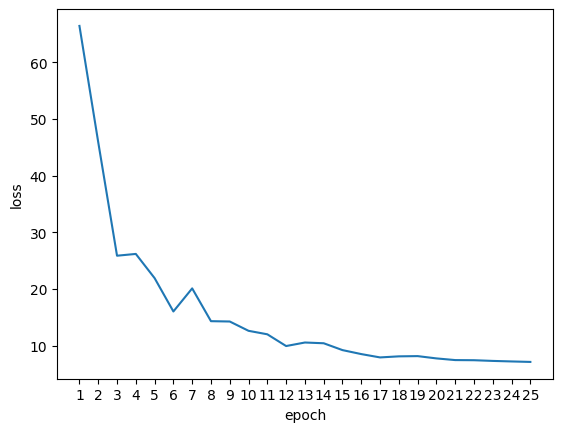


Training complete
Training complete. Validation results:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           L     0.9863    1.0000    0.9931        72
           G     0.9889    0.9958    0.9923       714
           B     1.0000    1.0000    1.0000        10
           T     1.0000    1.0000    1.0000        79
           O     1.0000    1.0000    1.0000        64
          NR     0.0000    0.0000    0.0000         0

   micro avg     0.9905    0.9968    0.9936       939
   macro avg     0.8292    0.8326    0.8309       939
weighted avg     0.9905    0.9968    0.9936       939
 samples avg     0.9948    0.9991    0.9960       939

hamming loss: 0.002320185614849188
exact match ratio: 0.9860788863109049


In [ ]:
layers = [str(x) for x in range(0, 12)]
fine_tuning(layers, "all_layers_cased", config.C_BETO, num_epochs=NUM_EPOCHS, gradient_accumulator_size=GRADIENT_ACCUMULATOR_SIZE, embeddings=False)

V2

In [16]:
#Obtener datasets
datasets = CustomDataset(config.TRACK2,
                         batch_size = BATCH_SIZE,
                         version = "v2",
                         modelname = config.C_BETO)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

...dataloader for train completed
...dataloader for dev completed
...dataloader for test completed


train_size:1069   val_size:862
------------------------


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1 / 25 :
Batch 0/134 avg loss: 55.22159 55.22159 55.22159
Batch 20/134 avg loss: 89.41050 349.53592 15.30177
Batch 40/134 avg loss: 81.51162 349.53592 9.95347
Batch 60/134 avg loss: 82.36624 375.44284 9.22472
Batch 80/134 avg loss: 75.22279 375.44284 9.00566
Batch 100/134 avg loss: 75.80820 749.65729 5.59700
Batch 120/134 avg loss: 70.50278 749.65729 3.83835
Batch 133/134 avg loss: 67.17204 749.65729 3.83835

	Average training loss: 67.17204
	Training epoch took: 0:00:47

	Validation

	F1Scores: [0.17977528274059296, 0.913294792175293, 0.0, 0.2767075300216675, 0.13822893798351288, 0.0]

	EvalLoss: 6987.52490234375
	Validation took: 0:00:03

Epoch 2 / 25 :
Batch 0/134 avg loss: 31.83877 31.83877 31.83877
Batch 20/134 avg loss: 78.74426 403.67517 3.74788
Batch 40/134 avg loss: 67.99425 403.67517 3.74788
Batch 60/134 avg loss: 61.44194 403.67517 2.36452
Batch 80/134 avg loss: 54.96194 403.67517 2.36452
Batch 100/134 avg loss: 55.45265 724.83160 0.82600
Batch 120/134 avg loss: 49.41

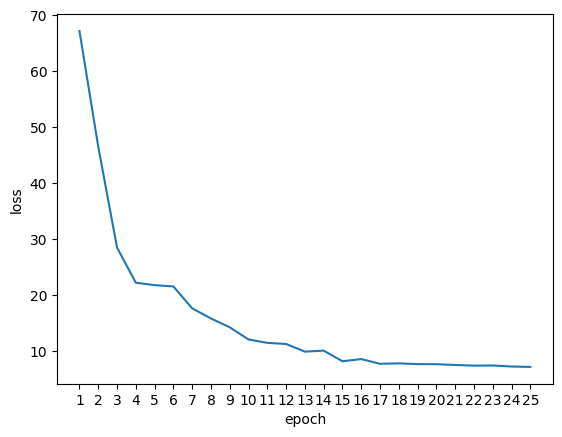


Training complete
Training complete. Validation results:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           L     1.0000    1.0000    1.0000        72
           G     0.9930    0.9944    0.9937       714
           B     1.0000    1.0000    1.0000        10
           T     0.9873    0.9873    0.9873        79
           O     1.0000    1.0000    1.0000        64
          NR     0.0000    0.0000    0.0000         0

   micro avg     0.9936    0.9947    0.9941       939
   macro avg     0.8301    0.8303    0.8302       939
weighted avg     0.9936    0.9947    0.9941       939
 samples avg     0.9967    0.9984    0.9969       939

hamming loss: 0.0021268368136117557
exact match ratio: 0.9872389791183295


In [17]:
layers = [str(x) for x in range(0, 12)]
fine_tuning(layers, "all_layers_cased", config.C_BETO, num_epochs=NUM_EPOCHS, gradient_accumulator_size=GRADIENT_ACCUMULATOR_SIZE)